In [1]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import pickle
import pandas as pd

In [2]:
# load the frequency data

with open('balearic_frequency_cleaned.pkl', 'rb') as file:
    frequency_data_raw = pickle.load(file)

frequency_data_raw.index = frequency_data_raw.index.tz_localize('UTC')
frequency_data_raw.index = frequency_data_raw.index.tz_convert('Europe/Madrid')

In [3]:
# load the generation data

with open('generation_data.pkl', 'rb') as file:
    generation_data = pickle.load(file)



In [4]:
from events import get_events

# compute the events

positive_events = get_events(frequency_data_raw, (frequency_data_raw >= 150), allow_overlap=True, event_end=0)
negative_events = get_events(frequency_data_raw, (frequency_data_raw <= -150), allow_overlap=True, event_end=0)

In [5]:
renewables_columns = [
    'generation_solar',
    'generation_wind',
    'generation_other_renewables',
]

others_columns = [
    'generation_waste',
    'generation_cogeneration',
    'generation_auxiliary',
]

generation_data['generation_renewables'] = generation_data[renewables_columns].sum(axis=1)

generation_data['generation_others'] = generation_data[renewables_columns].sum(axis=1)

generation_data.drop(columns=renewables_columns, inplace=True)
generation_data.drop(columns=others_columns, inplace=True)

In [6]:
from clustering import get_features

features_low = get_features(generation_data, negative_events)

features_high = get_features(generation_data, positive_events)


In [7]:
for column in features_high.columns:
        if column.startswith('generation_') or column.startswith('balearic') or column.startswith('demand_real'):
            features_high = features_high.drop(column, axis=1)

features_high = features_high.drop('Start', axis=1)
features_high = features_high.drop('End', axis=1)

In [8]:
for column in features_low.columns:
        if column.startswith('generation_') or column.startswith('balearic') or column.startswith('demand_real'):
            features_low = features_low.drop(column, axis=1)

features_low = features_low.drop('Start', axis=1)
features_low = features_low.drop('End', axis=1)

In [9]:
features_high = features_high.apply(pd.to_numeric, errors='coerce')
features_low = features_low.apply(pd.to_numeric, errors='coerce')

In [10]:
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 60,
    "max_iter": 300,
    "random_state": 100,
}


### Calculate the SSE and the silhouette coefficient to determine the number of clusters

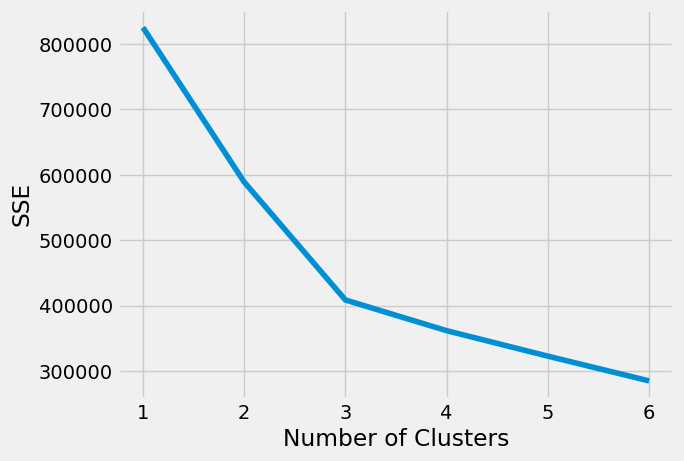

In [11]:

sse = []
for k in range(1, 7):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(features_low)
    sse.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, 7), sse)
plt.xticks(range(1, 7))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

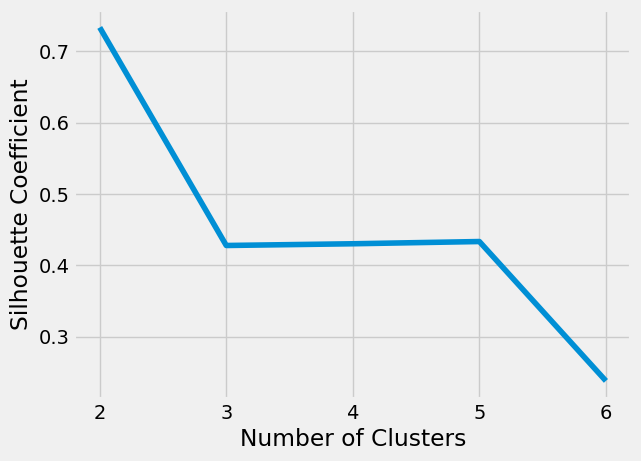

In [12]:

silhouette_coefficients = []


for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(features_low)
    score = silhouette_score(features_low, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 7), silhouette_coefficients)
plt.xticks(range(2, 7))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()


### The Silhouette Coefficient stays the same for 3, 4 and 5 but the SSE decreases

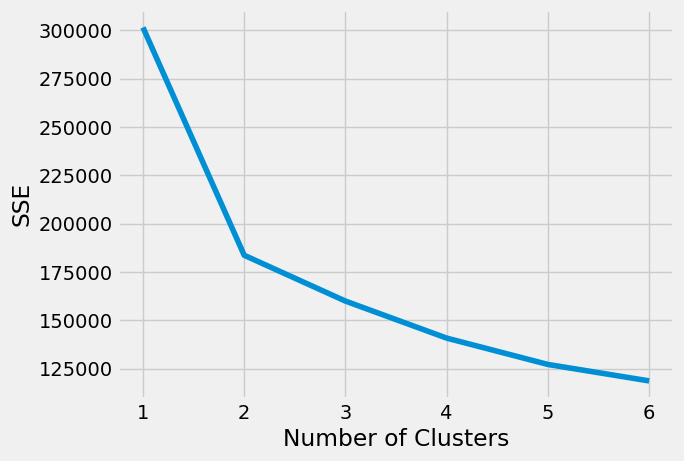

In [13]:
# A list holds the SSE values for each k
sse = []
for k in range(1, 7):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(features_high)
    sse.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, 7), sse)
plt.xticks(range(1, 7))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

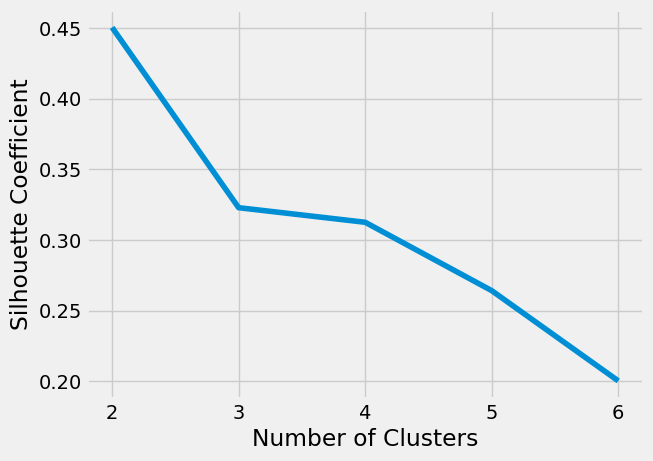

In [14]:

silhouette_coefficients = []


for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(features_high)
    score = silhouette_score(features_high, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 7), silhouette_coefficients)
plt.xticks(range(2, 7))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [15]:
def format_column_name(col):
    # Criteria for adding " Frequency" at the end
    criteria = ['emv_', 'ema_', 'squared_deviations']
    # Split by underscore and capitalize each word
    words = [word.capitalize() for word in col.split('_')]
    # Join back with space
    formatted_name = ' '.join(words)
    # Check if any criteria is in the original column name and add " Frequency" if true
    if any(crit in col for crit in criteria):
        formatted_name += ' Frequency'
    return formatted_name

In [16]:
# Create a mapping from old column names to new column names
new_columns = {col: format_column_name(col) for col in features_high.columns}

# Rename the columns in features_high
features_high.rename(columns=new_columns, inplace=True)

# Create a mapping from old column names to new column names
new_columns = {col: format_column_name(col) for col in features_low.columns}

# Rename the columns in X_test
features_low.rename(columns=new_columns, inplace=True)

/Users/zakarieasharfeddine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zakarieasharfeddine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zakarieasharfeddine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zakarieasharfeddine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

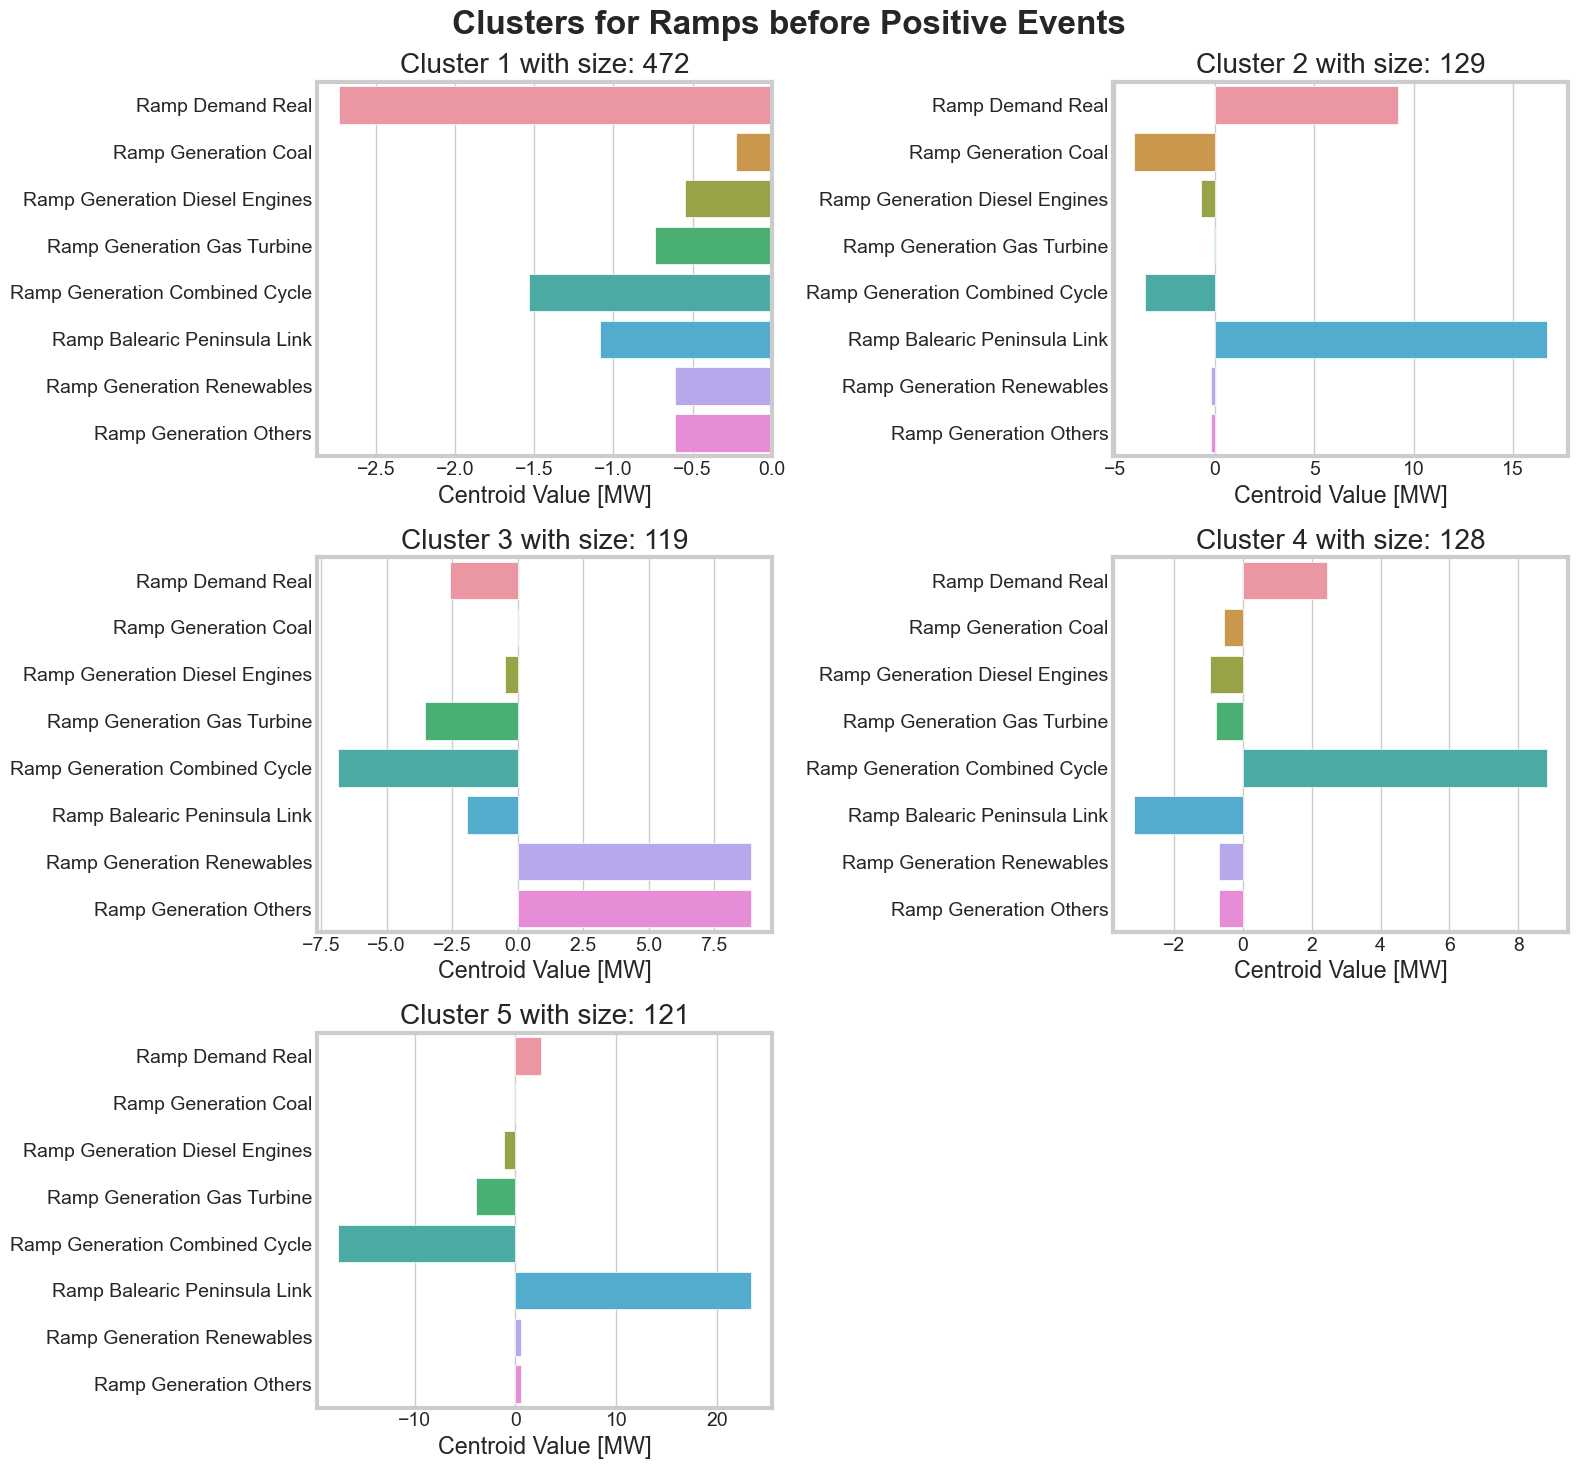

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

n_clusters_high = 5

kmeans_high = KMeans(n_clusters=n_clusters_high, **kmeans_kwargs)
kmeans_high.fit(features_high)

df_centroids_original = pd.DataFrame(kmeans_high.cluster_centers_, columns=features_high.columns)

# Set Seaborn style for a white background in the plot display
sns.set_style("whitegrid")

kmeans_high = KMeans(n_clusters=5, **kmeans_kwargs)
kmeans_high.fit(features_high)

#original_centroids = scaler.inverse_transform(kmeans_high.cluster_centers_)
df_centroids_original = pd.DataFrame(kmeans_high.cluster_centers_, columns=features_high.columns)

# Calculate the number of rows needed for the subplots (2 clusters per row)
num_clusters = len(df_centroids_original)
num_rows = -(-num_clusters // 2)  # Ceiling division to handle odd numbers of clusters

# Set dimensions for each subplot and the figure
subplot_height = 5  # Adjust based on your subplot vertical size needs
subplot_width = 8  # This will be the width for each subplot column
total_fig_width = subplot_width * 2  # Since we want 2 clusters per row
total_fig_height = subplot_height * num_rows

plt.figure(figsize=(total_fig_width, total_fig_height))
plt.suptitle("Clusters for Ramps before Positive Events", fontsize=24, fontweight='bold')

for i, (idx, row) in enumerate(df_centroids_original.iterrows()):
    points_in_cluster = features_high[kmeans_high.labels_ == i]
    ax = plt.subplot(num_rows, 2, i+1)  # Change to 2 columns
    sns.barplot(x=row.values, y=row.index, orient='h')
    plt.title(f'Cluster {i+1} with size: {len(points_in_cluster)}')
    plt.xlabel('Centroid Value [MW]')

plt.tight_layout()
plt.savefig('plots/clustering_positive_events.pdf', format='pdf', facecolor='white')
plt.show()

/Users/zakarieasharfeddine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zakarieasharfeddine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zakarieasharfeddine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zakarieasharfeddine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

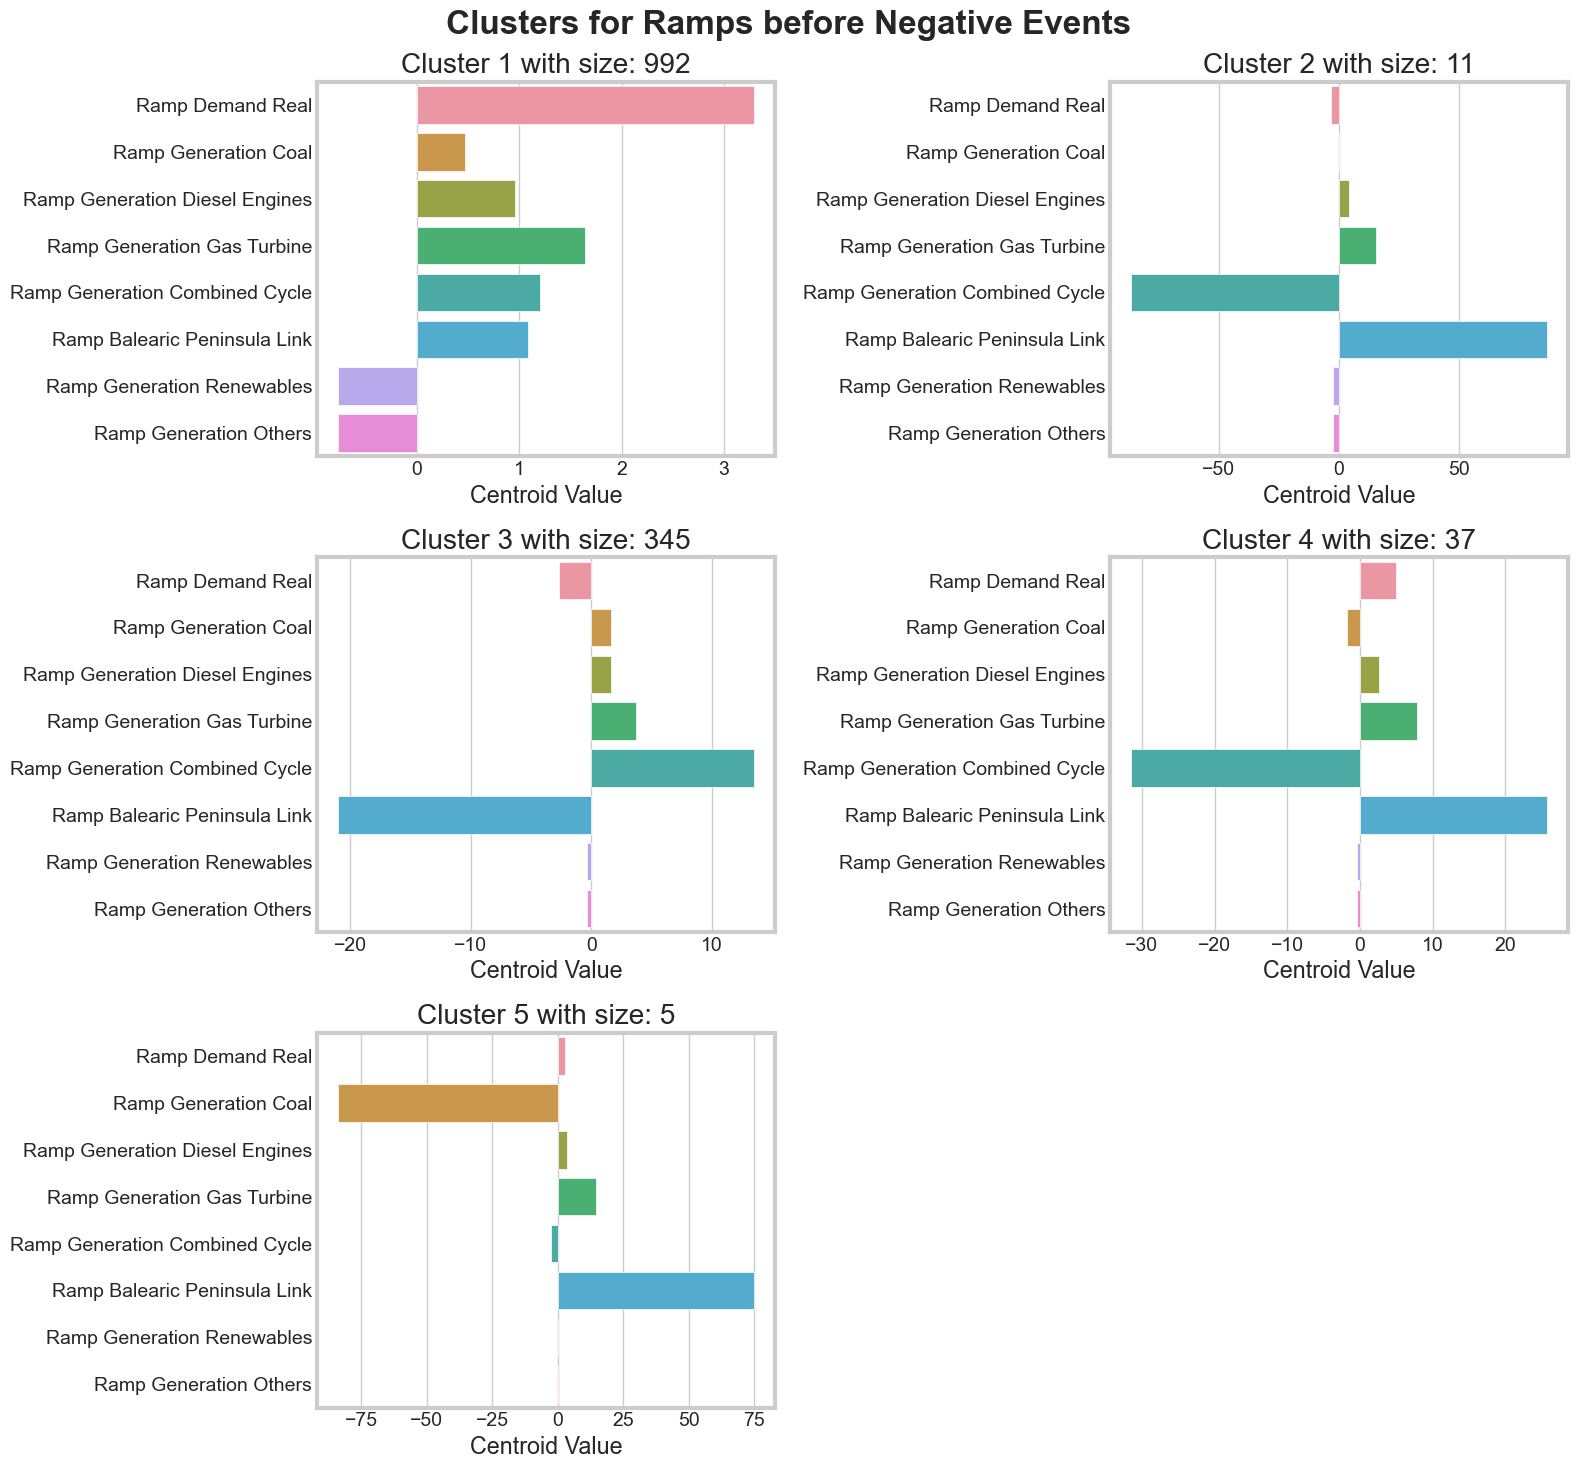

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

n_clusters_low = 5

kmeans_low = KMeans(n_clusters=n_clusters_low, **kmeans_kwargs)
kmeans_low.fit(features_low)

# Convert centroids to DataFrame
df_centroids = pd.DataFrame(kmeans_low.cluster_centers_, columns=features_low.columns)

# Set Seaborn style for a white background in the plot display
sns.set_style("whitegrid")

# Calculate the number of rows needed for the subplots (2 clusters per row)
num_clusters = len(df_centroids)
num_rows = -(-num_clusters // 2)  # Ceiling division to handle odd numbers of clusters

# Set dimensions for each subplot and the figure
subplot_height = 5  # Adjust based on your subplot vertical size needs
subplot_width = 8  # This will be the width for each subplot column
total_fig_width = subplot_width * 2  # Since we want 2 clusters per row
total_fig_height = subplot_height * num_rows

plt.figure(figsize=(total_fig_width, total_fig_height))

plt.suptitle("Clusters for Ramps before Negative Events", fontsize=24, fontweight='bold')


for i, (idx, row) in enumerate(df_centroids.iterrows()):
    points_in_cluster = features_low[kmeans_low.labels_ == i]
    ax = plt.subplot(num_rows, 2, i+1)  # Change to 2 columns
    sns.barplot(x=row.values, y=row.index, orient='h')
    plt.title(f'Cluster {i+1} with size: {len(points_in_cluster)}')
    plt.xlabel('Centroid Value')

plt.tight_layout()
plt.savefig('plots/clustering_negative_events.pdf', format='pdf', facecolor='white')
plt.show()


### Why not a cluster size of 3?
Considering the SSE and Silhoutte Coefficient a cluster size of 3 would be a better Choice. If we do that we would lose cluster 5. However, cluster 5 has valuable information. It indicates that the rapid drop of the coal generation caused an increase of the HVDC ramp to mitigate an extreme frequency deviation. The drop of the coal generation could be due to generator tripping.

/Users/zakarieasharfeddine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zakarieasharfeddine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zakarieasharfeddine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zakarieasharfeddine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

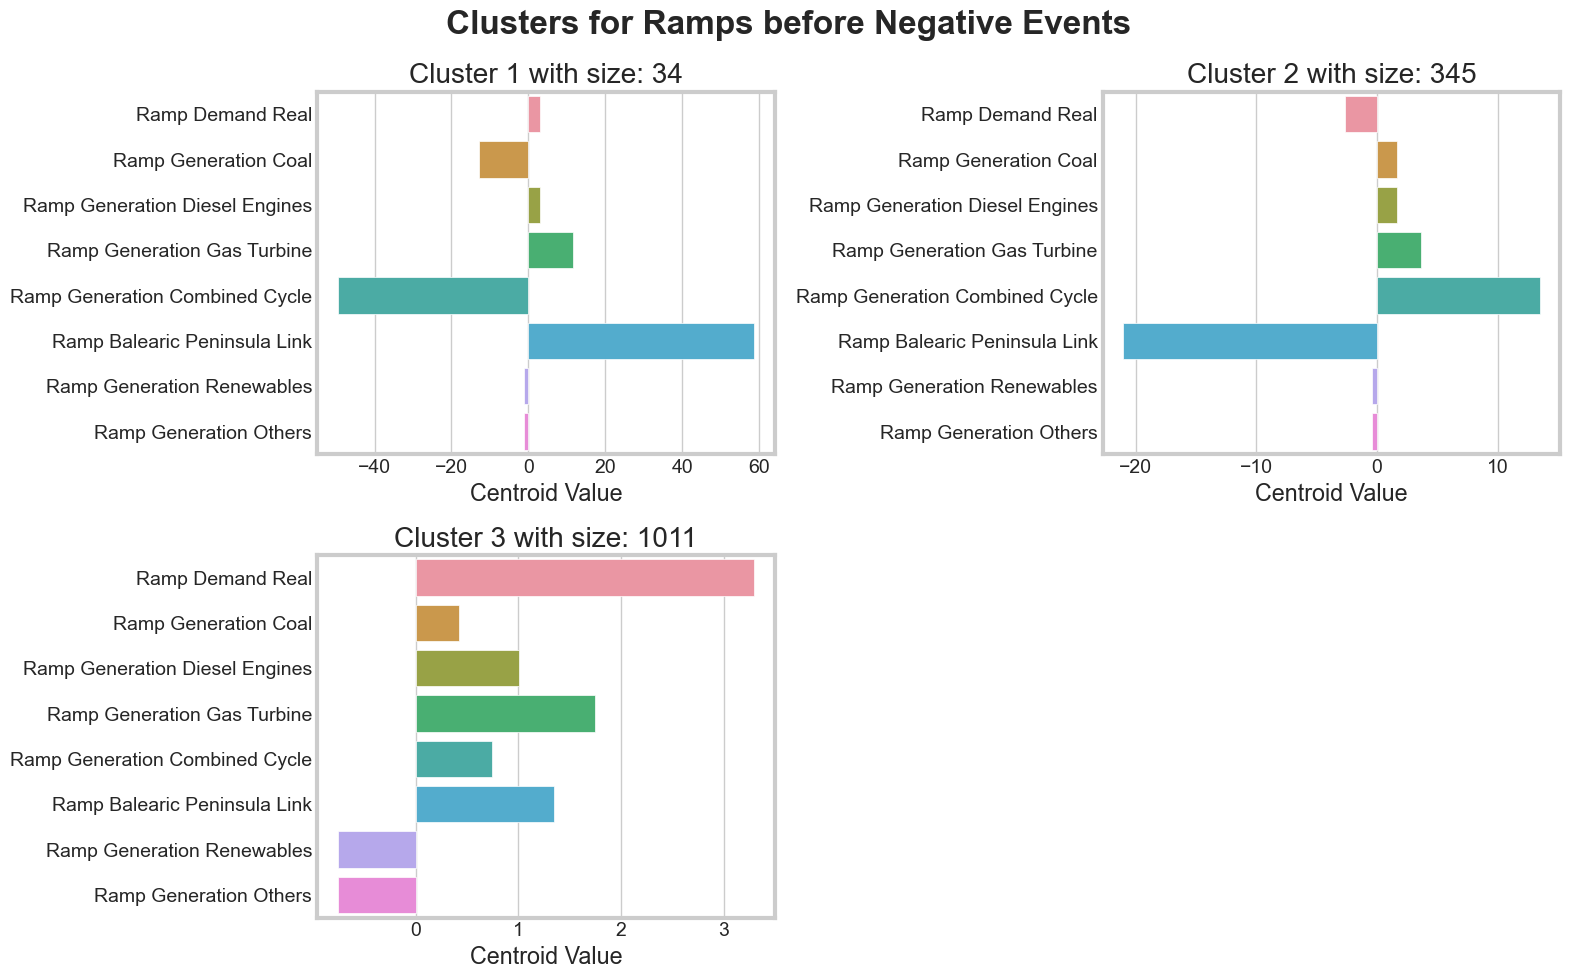

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

n_clusters_low = 3

kmeans_low = KMeans(n_clusters=n_clusters_low, **kmeans_kwargs)
kmeans_low.fit(features_low)

# Convert centroids to DataFrame
df_centroids = pd.DataFrame(kmeans_low.cluster_centers_, columns=features_low.columns)

# Set Seaborn style for a white background in the plot display
sns.set_style("whitegrid")

# Calculate the number of rows needed for the subplots (2 clusters per row)
num_clusters = len(df_centroids)
num_rows = -(-num_clusters // 2)  # Ceiling division to handle odd numbers of clusters

# Set dimensions for each subplot and the figure
subplot_height = 5  # Adjust based on your subplot vertical size needs
subplot_width = 8  # This will be the width for each subplot column
total_fig_width = subplot_width * 2  # Since we want 2 clusters per row
total_fig_height = subplot_height * num_rows

plt.figure(figsize=(total_fig_width, total_fig_height))

plt.suptitle("Clusters for Ramps before Negative Events", fontsize=24, fontweight='bold')


for i, (idx, row) in enumerate(df_centroids.iterrows()):
    points_in_cluster = features_low[kmeans_low.labels_ == i]
    ax = plt.subplot(num_rows, 2, i+1)  # Change to 2 columns
    sns.barplot(x=row.values, y=row.index, orient='h')
    plt.title(f'Cluster {i+1} with size: {len(points_in_cluster)}')
    plt.xlabel('Centroid Value')

plt.tight_layout()
plt.savefig('plots/clustering_negative_events.pdf', format='pdf', facecolor='white')
plt.show()
